## Data Acquisition from TON_IoT Network dataset

In [390]:
# Import data processing libraries
import os
import platform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import libraries for RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Import libraries for KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
#Run if processedNetworkDS.csv does not exist. If it exists, run the cell that follows this one

# Datasets file path
folder_path = r'/Users/ag2356/Documents/IoTMasterTHESIS/processedNetworkDS'
all_files = os.listdir(folder_path)

# Filter out non-CSV files
csv_files = [f for f in all_files if f.endswith('.csv')]
# Create a list to hold the dataframes
df_list = []
for csv in csv_files:
    file_path = os.path.join(folder_path, csv)
    try:
        # Try reading the file using default UTF-8 encoding
        df = pd.read_csv(file_path)
        df_list.append(df)
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
            df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
            df_list.append(df)
        except Exception as e:
            print(f"Could not read file {csv} because of error: {e}")
    except Exception as e:
        print(f"Could not read file {csv} because of error: {e}")
        
print("memory warning, might need to specify datatypes")

In [128]:
# Concatenate all data into one DataFrame
ton_nw_df = pd.concat(df_list, ignore_index=True)

# Save the final result to a new CSV file
ton_nw_df.to_csv(os.path.join(folder_path, 'combined_file_NW_TON.csv'), index=False)

In [ ]:
# Check dataset size
ton_nw_df.info

## Preprocessing

In [ ]:
# Remove rows with scanning, dos, password attacks etc.
list1 = ['scanning', 'backdoor', 'password', 'mitm', 'xss', 'ransomware', 'injection', 'dos']
ton_nw_df = ton_nw_df[ton_nw_df.type.isin(list1) == False]

#Remove columns we do not need for now, which is most of them except for timestamp ts, attack label and type and network traffic info etc
prep_df = ton_nw_df[['ts', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'label']]
#Removes type column, henceforth all data labelled as 1 is ddos, 0 is normal

print(prep_df.head(3))
prep_df.info()

In [21]:
# Save the final result to a new CSV file
prep_df.to_csv(os.path.join(folder_path, 'preprocessed.csv'), index=False)

### Aggregated dataset acquisition

In [6]:
#START HERE IF NOT FIRST RUN
# File path to preprocessed dataset in csv format
file_path = os.path.join('/Users/ag2356/Documents/IoTMasterTHESIS/processedNetworkDS/preprocessed.csv')

# Read the file
prep_df = pd.read_csv(file_path)
prep_df.shape   # Display the shape of dataset

(13922776, 6)

### TIMESERIES DATA ANALYSIS

In [89]:
#Remove rows with null datapoints
newdf = prep_df.dropna()

#Change datatype of ts from int64 to datetime
newdf['ts'] = pd.to_datetime(newdf['ts'], unit='s')

# Group by the datetime column and average other columns
newdf = newdf.groupby('ts', as_index=False).mean()

newdf.shape

#we have aggregated the dataset by datetime values, reducing the number of rows

(244760, 6)

In [91]:
#Convert label column to ints 0 and 1
newdf['label'] = newdf['label'].astype(int)
newdf.head(5)

,ts,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,label
0,2019-04-02 09:45:58,126091.000000,7455609.5,1.0,118.0,0
1,2019-04-02 09:45:59,0.000000,0.0,0.0,0.0,0
2,2019-04-02 09:46:02,0.000000,0.0,2.0,354.0,0
3,2019-04-02 09:46:04,0.333333,21.0,0.0,0.0,0
4,2019-04-02 09:46:09,0.000000,0.0,0.0,0.0,0


### Data cleaning

Original Data: 244760 rows
Filtered Data: 46023 rows


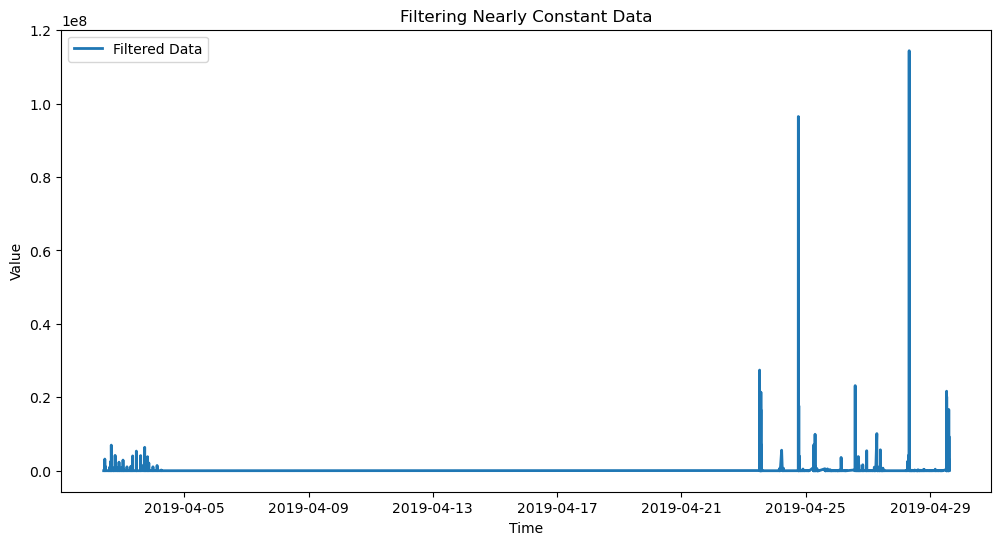

(244760, 7)

In [93]:
#Filter unchanging data points
data = newdf
column = 'dst_ip_bytes' #this column is indicated as the most meaningful feature by data analysis and literature
threshold = 200

# Function to filter nearly constant data
def filter_nearly_constant(data, column, threshold):
    """
    Filters rows from the dataset where the values in the specified column 
    are constant or nearly constant over time.
    Args:
    - data (pd.DataFrame): The input dataframe.
    - column (str): The column to analyze.
    - threshold (float): The standard deviation threshold for filtering.
    Returns:
    - pd.DataFrame: A filtered dataframe with non-constant slices.
    """
    # Calculate the rolling standard deviation
    data['std_dev'] = data[column].rolling(window=2, center=True).std()
    
    # Filter out slices with std_dev below the threshold
    filtered_data = data[data['std_dev'] > threshold].drop(columns=['std_dev'])
    return filtered_data

# Apply
filtered_data = filter_nearly_constant(data, column, threshold)

# Display results
print(f"Original Data: {len(data)} rows")
print(f"Filtered Data: {len(filtered_data)} rows")

# Plot filtered data for visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['ts'], filtered_data['dst_ip_bytes'], label='Filtered Data', linewidth=2)
plt.legend()
plt.title('Filtering Nearly Constant Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

data.shape


In [95]:
filtered_df.head()

,ts,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,label
98789,2019-04-23 12:10:10,843.0,547510.5,843.0,44070.0,0
98790,2019-04-23 12:10:12,78.0,8244.0,0.0,0.0,0
98816,2019-04-23 12:11:04,0.5,31.5,3.0,1014.0,0
98817,2019-04-23 12:11:05,3.0,459.0,0.0,0.0,0
98875,2019-04-23 12:12:56,1.0,73.0,1.0,344.0,0


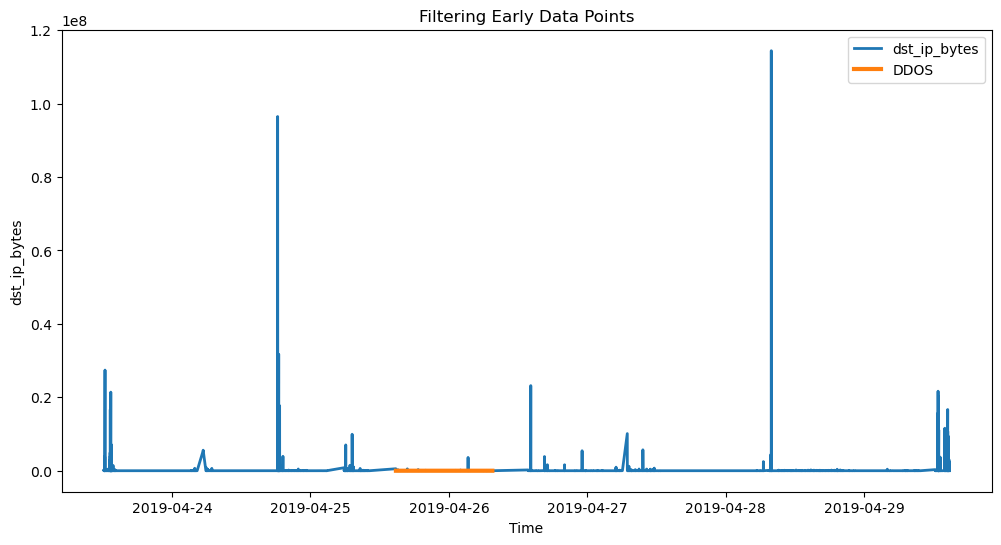

In [147]:
# Threshold for column 'ts'
threshold = '2019-04-21' #removing less meaningful dates in dataset
filtered_df_ddos = filtered_df[filtered_df['label']==1]

# Drop rows where column 'ts' is below the threshold
filtered_df = filtered_data[filtered_data['ts'] >= threshold]

# Plot the filtered data for visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['ts'], filtered_df['dst_ip_bytes'], label='dst_ip_bytes', linewidth=2)
plt.plot(filtered_df_ddos['ts'], filtered_df_ddos['label'], label='DDOS', linewidth=3)

plt.legend()
plt.title('Filtering Early Data Points')
plt.xlabel('Time')
plt.ylabel('dst_ip_bytes')
plt.show()

## STATISTICAL ANALYSIS

### Using Robust Scaler

In [151]:
npds = filtered_df[['ts', 'dst_ip_bytes', 'label']]
to_np.head

<bound method NDFrame.head of                         ts  dst_ip_bytes  label
98789  2019-04-23 12:10:10  44070.000000      0
98790  2019-04-23 12:10:12      0.000000      0
98816  2019-04-23 12:11:04   1014.000000      0
98817  2019-04-23 12:11:05      0.000000      0
98875  2019-04-23 12:12:56    344.000000      0
...                    ...           ...    ...
244749 2019-04-29 14:45:45   2466.428571      0
244750 2019-04-29 14:45:47   2030.000000      0
244751 2019-04-29 14:45:48    360.777778      0
244753 2019-04-29 14:45:50    973.000000      0
244754 2019-04-29 14:45:51    285.138889      0

[40519 rows x 3 columns]>

In [179]:
npds

array([[Timestamp('2019-04-23 12:10:10'), 44070.0, 0],
       [Timestamp('2019-04-23 12:10:12'), 0.0, 0],
       [Timestamp('2019-04-23 12:11:04'), 1014.0, 0],
       ...,
       [Timestamp('2019-04-29 14:45:48'), 360.77777777777777, 0],
       [Timestamp('2019-04-29 14:45:50'), 973.0, 0],
       [Timestamp('2019-04-29 14:45:51'), 285.1388888888889, 0]],
      dtype=object)

In [183]:
from sklearn.preprocessing import RobustScaler

# Specify columns to scale
columns_to_scale = ['dst_ip_bytes']

# Apply Robust Scaling
scaler = RobustScaler()
to_np[columns_to_scale] = scaler.fit_transform(to_np[columns_to_scale])

print(to_np)

                        ts  dst_ip_bytes  label
98789  2019-04-23 12:10:10     21.676522      0
98790  2019-04-23 12:10:12     -0.408168      0
98816  2019-04-23 12:11:04      0.099975      0
98817  2019-04-23 12:11:05     -0.408168      0
98875  2019-04-23 12:12:56     -0.235781      0
...                    ...           ...    ...
244749 2019-04-29 14:45:45      0.827827      0
244750 2019-04-29 14:45:47      0.609121      0
244751 2019-04-29 14:45:48     -0.227373      0
244753 2019-04-29 14:45:50      0.079429      0
244754 2019-04-29 14:45:51     -0.265277      0

[40519 rows x 3 columns]


/var/folders/b9/llvf92q129901l28xjhlvy8nd6fgds/T/ipykernel_93452/3883157449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_np[columns_to_scale] = scaler.fit_transform(to_np[columns_to_scale])


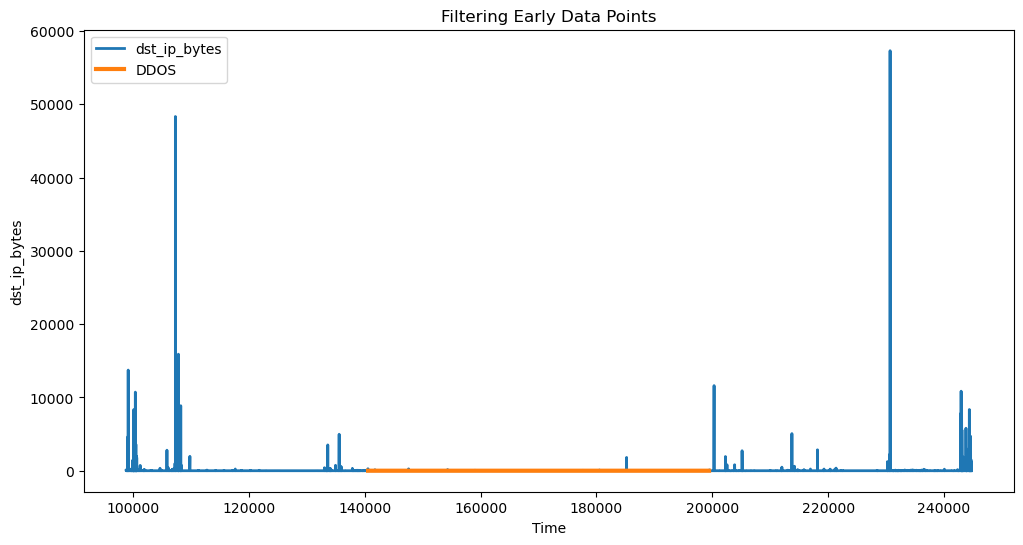

In [189]:
# Keep ddos data
to_np_ddos = to_np[to_np['label']==1]

# Plot the scaled data for visualization
plt.figure(figsize=(12, 6))
plt.plot(to_np['dst_ip_bytes'], label='dst_ip_bytes', linewidth=2)
plt.plot(to_np_ddos['label'], label='DDOS', linewidth=3)

plt.legend()
plt.title('Filtering Early Data Points')
plt.xlabel('Time')
plt.ylabel('dst_ip_bytes')
plt.show()

In [235]:
# Keep only best feature
newdf_best = to_np[['dst_ip_bytes']]

# Transform df to np array
anomaly_scores = newdf_best.to_numpy()

# Mean and standard deviation
mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)

# Set threshold as half a standard deviations from the mean (due to nature of dataset)
threshold = mean_score + 0.5 * std_score

print(f'Mean: {mean_score}')
print(f'Standard Dev.: {std_score}')
print(f'Threshold: {threshold}')

## INHERENTLY WEAK TO OUTLIERS!

Mean: 12.717376702151121
Standard Dev.: 437.11403864725435
Threshold: 231.2743960257783


In [243]:
# Set threshold at the 90th percentile
threshold = np.percentile(anomaly_scores, 90)
print(f'Threshold dst_ip_bytes: {threshold}')

Threshold dst_ip_bytes: 1.7864361479996658


In [245]:
# Keep labels and anomaly scores, using unscaled data
newdf = filtered_df[['dst_ip_bytes', 'label']]

y_true = filtered_df['label']  # Binary labels: 0 (normal), 1 (anomaly)
anomaly_scores = filtered_df[['dst_ip_bytes']]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, anomaly_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

#NOTE: UNSCALED

Optimal Threshold: 40.142857142857146


In [249]:
# Define the index range to delete
start_index = 61190
end_index = 180000

# Drop rows by index range
newdf = newdf.drop(newdf.index[start_index:end_index+1])

newdf.shape

(40519, 6)

/var/folders/b9/llvf92q129901l28xjhlvy8nd6fgds/T/ipykernel_93452/1410019520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['label'] = newdf['label'].astype(bool)


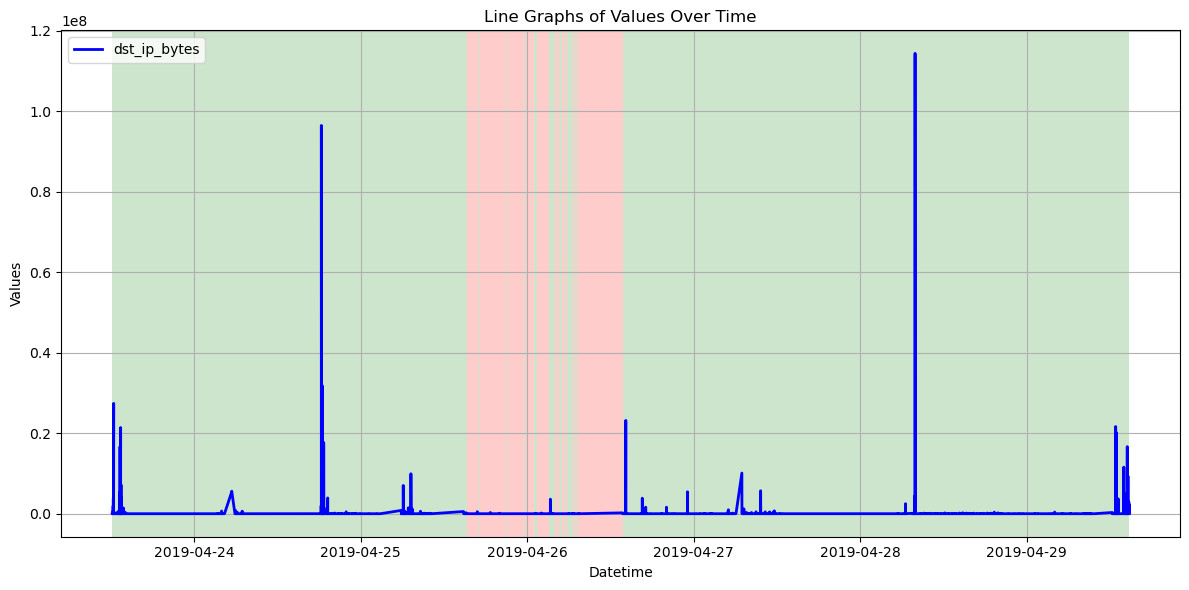

In [251]:
newdf = filtered_df

# Convert column 'label' from float to bool
newdf['label'] = newdf['label'].astype(bool)
newdf.head()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the time series
ax.plot(newdf['ts'],newdf['dst_ip_bytes'], label='dst_ip_bytes', color='blue', linewidth=2)

# Highlight background based on the boolean label
for i in range(len(newdf) - 1):
    if newdf['label'].iloc[i]:
        ax.axvspan(newdf['ts'].iloc[i], newdf['ts'].iloc[i + 1], color='red', alpha=0.2, lw=0)
    else:
        ax.axvspan(newdf['ts'].iloc[i], newdf['ts'].iloc[i + 1], color='green', alpha=0.2, lw=0)

# Format the plot
plt.title('Line Graphs of Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [253]:
#Convert label column to ints 0 and 1
newdf['label'] = newdf['label'].astype(int)
df = newdf.drop('ts', axis=1)

df.info #Check

/var/folders/b9/llvf92q129901l28xjhlvy8nd6fgds/T/ipykernel_93452/2834044255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['label'] = newdf['label'].astype(int)


<bound method DataFrame.info of           src_pkts   src_ip_bytes    dst_pkts  dst_ip_bytes  label
98789   843.000000  547510.500000  843.000000  44070.000000      0
98790    78.000000    8244.000000    0.000000      0.000000      0
98816     0.500000      31.500000    3.000000   1014.000000      0
98817     3.000000     459.000000    0.000000      0.000000      0
98875     1.000000      73.000000    1.000000    344.000000      0
...            ...            ...         ...           ...    ...
244749   77.714286    7980.000000   49.571429   2466.428571      0
244750   30.000000    3150.000000   16.000000   2030.000000      0
244751   18.500000    1594.888889    3.277778    360.777778      0
244753   37.928571    3294.928571   16.857143    973.000000      0
244754   18.555556    1483.277778    2.444444    285.138889      0

[40519 rows x 5 columns]>

In [262]:
df.head(10)

,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,label
98789,843.000000,547510.500000,843.000000,44070.0,0
98790,78.000000,8244.000000,0.000000,0.0,0
98816,0.500000,31.500000,3.000000,1014.0,0
98817,3.000000,459.000000,0.000000,0.0,0
98875,1.000000,73.000000,1.000000,344.0,0
98876,107.000000,6722.000000,228.000000,314343.0,0
98877,1.000000,63.000000,0.000000,0.0,0
98911,10.000000,2138.250000,10.000000,2542.5,0
98912,1.000000,65.000000,1.000000,336.0,0
98913,12.333333,946.666667,11.333333,10623.0,0


# Deep Learning

In [264]:
# Column 'label' is for normal (0) and anomaly (1), and others are features
X_reshaped = df.drop(columns=['label'])
y = df['label']

# Returns y = [label: eg. 0,1,0,0,1,0,1,...]
# X = [src_pkts, src_ip_bytes, dst_pkts, dst_ip_bytes]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
print(y.shape)
X_scaled.shape


(40519,)


(40519, 4)

In [266]:
# Reshape the data for RNN (samples, timesteps, features)
# Set window size to 10 time steps
timesteps = 10
X_reshaped = []
y_reshaped = []
for i in range(len(X_scaled) - timesteps):
    X_reshaped.append(X_scaled[i:i+timesteps])
    y_reshaped.append(y.iloc[i+timesteps])
X_reshaped = np.array(X_reshaped)
y_reshaped = np.array(y_reshaped)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)


X_reshaped.shape


(40509, 10, 4)

In [268]:

y = y.iloc[:-10]

# Build the RNN model
model = Sequential([
    Input(shape=(timesteps, X_reshaped.shape[2])),  # Explicit Input layer
    SimpleRNN(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Single unit for binary classification
])

# Compile the model with binary_crossentropy loss for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [270]:
# Train the model
history = model.fit(X_reshaped, y, epochs=20, batch_size=32)


Epoch 1/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.7250 - loss: 0.5844
Epoch 2/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.7239 - loss: 0.5652
Epoch 3/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.7205 - loss: 0.5522
Epoch 4/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.7208 - loss: 0.5671
Epoch 5/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.7230 - loss: 0.5645
Epoch 6/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.7214 - loss: 0.5652
Epoch 7/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.7234 - loss: 0.5727
Epoch 8/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.7282 - loss: 0.5679
Epoch 9/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.7220 - loss: 0.5449
Epoch 10/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.7664 - loss: 0.4350
Epoch 11/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - accuracy: 0.8334 - loss: 0.3431
Epoch 12

In [272]:
#GET PROBABILITIES (NOT LABELS)
y_pred_probs = model.predict(X_test)


254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


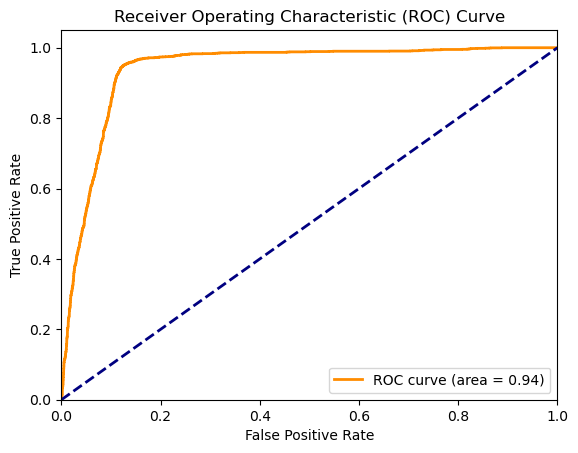

In [274]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [284]:
# Calculate Youden's J statistic: J = TPR - FPR
j_scores = tpr - fpr
optimal_threshold = thresholds[j_scores.argmax()]
print(f"Optimal Threshold: {optimal_threshold}")


Optimal Threshold: 0.6619832515716553


In [278]:
# Convert probabilities to binary predictions based on the optimal threshold
y_pred_binary = (y_pred_probs >= optimal_threshold).astype(int)

# Evaluate the model's performance using the binary predictions
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_binary)}")


Accuracy: 0.89607504319921
Confusion Matrix:
[[5168  728]
 [ 114 2092]]


## Linear Regression

Intercept: 0.2769276061637236
Coefficient: [-9.26213961e-09]


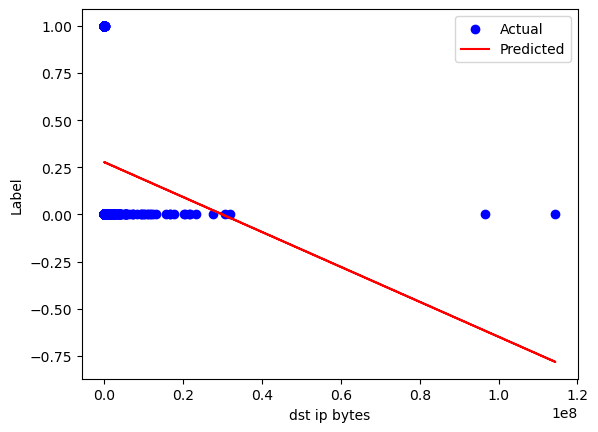

In [322]:
from sklearn.linear_model import LinearRegression

# Load dataset
df = filtered_df[['dst_ip_bytes','label']]

# Features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Create and train the model
model = LinearRegression()
model.fit(X, y)

# Predictions
predictions = model.predict(X)

# Results
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

# Visualization
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('dst ip bytes')
plt.ylabel('Label')
plt.legend()
plt.show()

In [349]:
y_pred

array([0.27531419, 0.27938799, 0.27939377, ..., 0.27914065, 0.27939245,
       0.27938252])

## Logistic Reg

Accuracy: 0.7330
Confusion Matrix:
[[5940    0]
 [2164    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5940
           1       0.00      0.00      0.00      2164

    accuracy                           0.73      8104
   macro avg       0.37      0.50      0.42      8104
weighted avg       0.54      0.73      0.62      8104



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


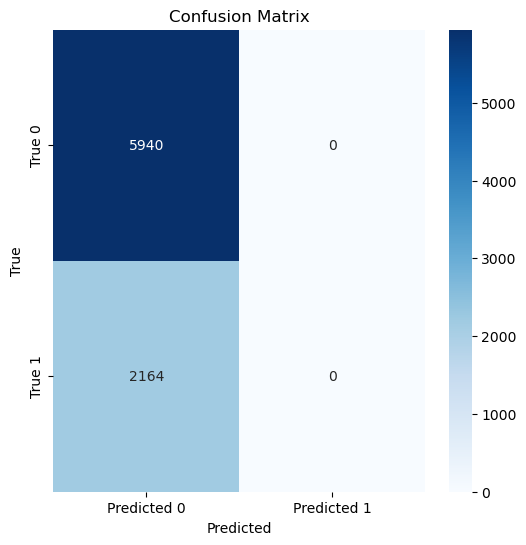

Coefficients: [[-13.54028553]]
Intercept: [-1.34785458]


In [357]:
# Load dataset
df = filtered_df[['dst_ip_bytes','label']]

# Features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Model coefficients (Optional)
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')


# BAD MODEL, DO NOT USE

In [100]:
model.trainable = False


Training Accuracy: [0.7230738997459412, 0.7231479287147522, 0.7218889594078064, 0.723246693611145, 0.7231479287147522, 0.7231232523918152, 0.7253202795982361, 0.7293688058853149, 0.7312942743301392, 0.8011059165000916, 0.8467254042625427, 0.8704485297203064, 0.8708682060241699, 0.8782739639282227, 0.8847663402557373, 0.8734602332115173, 0.8873090147972107, 0.8852847218513489, 0.8865437507629395, 0.8891357183456421]
Training Loss: [0.5739063024520874, 0.5657142400741577, 0.5632479786872864, 0.5679990649223328, 0.5602746605873108, 0.5665102601051331, 0.5695599913597107, 0.5624178051948547, 0.5313435196876526, 0.38714516162872314, 0.325633704662323, 0.29308438301086426, 0.2929172217845917, 0.2805883586406708, 0.2722025215625763, 0.30067890882492065, 0.2681795060634613, 0.2699836790561676, 0.2696480453014374, 0.26606571674346924]
Validation Accuracy: None
Validation Loss: None


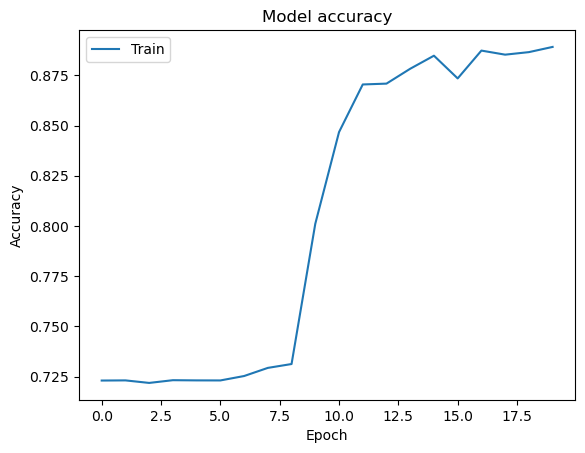

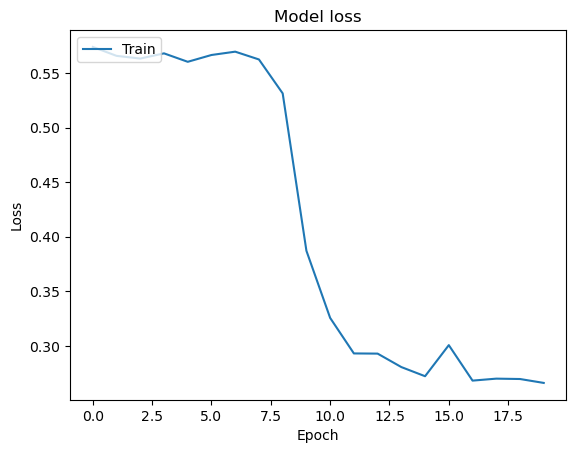

In [363]:
# Print the history of training accuracy and loss
print("Training Accuracy:", history.history['accuracy'])
print("Training Loss:", history.history['loss'])

# If using validation data:
print("Validation Accuracy:", history.history.get('val_accuracy'))
print("Validation Loss:", history.history.get('val_loss'))


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## KNN

In [376]:
df.head()

,dst_ip_bytes,label
98789,44070.0,0
98790,0.0,0
98816,1014.0,0
98817,0.0,0
98875,344.0,0


In [378]:
# Split dataset into features and target variable
df = newdf.drop("ts", axis=1)

X = df.drop("label", axis=1)  # Features
y = df["label"]              # Target

y = (y > 0.5).astype(int)  # Binary classification: values above 0.5 become class 1, others class 0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [380]:
# Train the KNN classifier
k = 2  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

In [382]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[8501  392]
 [ 890 2373]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8893
           1       0.86      0.73      0.79      3263

    accuracy                           0.89     12156
   macro avg       0.88      0.84      0.86     12156
weighted avg       0.89      0.89      0.89     12156



In [384]:
# Test predictions
print("\nTest Set Predictions:")
print(pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred}))


Test Set Predictions:
       Actual  Predicted
0           0          0
1           1          1
2           0          0
3           0          0
4           0          0
...       ...        ...
12151       0          0
12152       0          0
12153       0          0
12154       1          1
12155       0          0

[12156 rows x 2 columns]


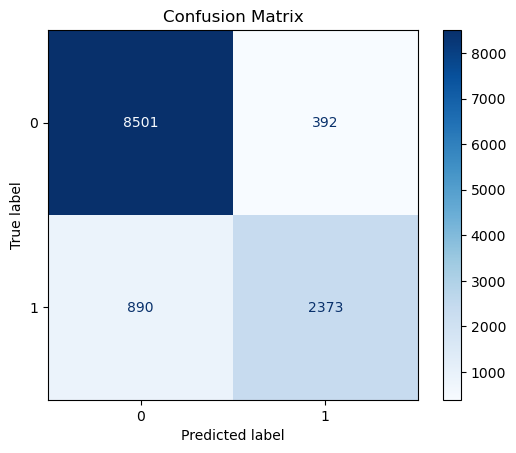

In [394]:
# Confusion matrix for classification
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### KNN performs better than regression